<a href="https://colab.research.google.com/github/muzammilkhattri/HacktoberFest-Hackathon/blob/main/Issue%20%233/QuarkAI_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [137]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import math
import seaborn as sns

# Dataset Creation

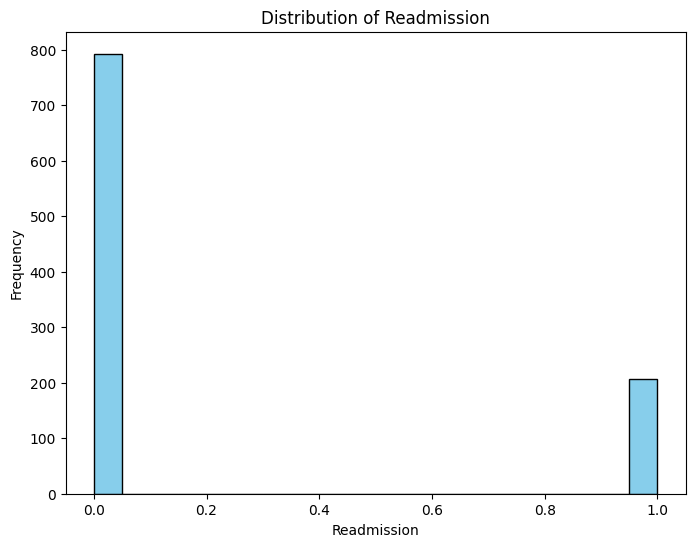

In [156]:
np.random.seed(42)

# Number of patients
num_patients = 1000

# demographics data
ages = np.random.randint(18, 90, size=num_patients)
genders = np.random.choice(['Male', 'Female'], size=num_patients)
ethnicity = np.random.choice(['White', 'Black', 'Asian', 'Hispanic'], size=num_patients)

diagnosis_codes = np.random.choice(['ICD_A', 'ICD_B', 'ICD_C', 'ICD_D'], size=num_patients)

blood_pressure_systolic = np.random.normal(120, 20, num_patients)
blood_pressure_diastolic = np.random.normal(80, 10, num_patients)
heart_rate = np.random.normal(75, 10, num_patients)
oxygen_saturation = np.random.normal(95, 3, num_patients)

blood_sugar = np.random.normal(110, 20, num_patients)
cholesterol = np.random.normal(200, 50, num_patients)
creatinine = np.random.normal(1.0, 0.3, num_patients)

treatment_history = np.random.randint(0, 2, size=num_patients)

sudden_bp_drop = np.random.choice([0, 1], size=num_patients, p=[0.8, 0.2])

readmission = np.random.choice([0, 1], size=num_patients, p=[0.8, 0.2])

data = {
    'Age': ages,
    'Gender': genders,
    'Ethnicity': ethnicity,
    'Diagnosis_Code': diagnosis_codes,
    'BP_Systolic': blood_pressure_systolic,
    'BP_Diastolic': blood_pressure_diastolic,
    'Heart_Rate': heart_rate,
    'Oxygen_Saturation': oxygen_saturation,
    'Blood_Sugar': blood_sugar,
    'Cholesterol': cholesterol,
    'Creatinine': creatinine,
    'Treatment_History': treatment_history,
    'Sudden_BP_Drop': sudden_bp_drop,
    'Readmission': readmission
}

df = pd.DataFrame(data)

df.to_csv('icu_readmission_data.csv', index=False)

# Plot readmission
plt.figure(figsize=(8, 6))
plt.hist(df['Readmission'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Readmission')
plt.ylabel('Frequency')
plt.title('Distribution of Readmission')
plt.show()



# Preprocessing

In [157]:
# Handling Missing Data
numeric_features = df.select_dtypes(include=[np.number]).columns
categorical_features = df.select_dtypes(include=['object']).columns

# Imputers for missing data
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Impute numeric and categorical columns
df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

# Handling Outliers using Z-score method
z_scores = np.abs(stats.zscore(df[numeric_features]))
df = df[(z_scores < 3).all(axis=1)]

# 3. Encoding Categorical Variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_columns = pd.DataFrame(encoder.fit_transform(df[categorical_features]),
                               columns=encoder.get_feature_names_out(categorical_features))

# Concatenate the encoded columns with the original dataframe and drop original categorical columns
df = pd.concat([df, encoded_columns], axis=1)
df = df.drop(categorical_features, axis=1)

# Check and handle missing values in the target column ('Readmission')
if df['Readmission'].isnull().sum() > 0:
    df = df.dropna(subset=['Readmission'])

X = df.drop(columns='Readmission')
y = df['Readmission']


# y = np.where(y > 0.5, 1, 0)


X = X.replace({np.nan: 0})

# Apply SMOTE
if X.isnull().sum().sum() == 0:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
else:
    print("There are still missing values in the features.")


# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [158]:
numeric_features = df.select_dtypes(include=[np.number]).columns
categorical_features = df.select_dtypes(include=['object']).columns

# Handling missing values and imputation
if len(categorical_features) == 0:
    print("No categorical features found in the DataFrame.")
else:
    numeric_imputer = SimpleImputer(strategy='median')
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])
    df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

# Outlier removal using Z-score method
z_scores = np.abs(stats.zscore(df[numeric_features]))
df = df[(z_scores < 3).all(axis=1)]

# Check and handle missing values in target column
if df['Readmission'].isnull().sum() > 0:
    df = df.dropna(subset=['Readmission'])

No categorical features found in the DataFrame.


# Feature Engineering

In [159]:

rf = RandomForestClassifier()
rf.fit(X, y)

importances = rf.feature_importances_

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

threshold = 0.1
selected_features_rf = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()

print("Selected features using Random Forest:", selected_features_rf)


Selected features using Random Forest: ['Oxygen_Saturation', 'BP_Systolic', 'Cholesterol', 'Heart_Rate', 'Blood_Sugar', 'Creatinine', 'BP_Diastolic']


In [160]:
# Feature Engineering Block
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding for categorical variables
if len(categorical_features) > 0:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_columns = pd.DataFrame(encoder.fit_transform(df[categorical_features]),
                                   columns=encoder.get_feature_names_out(categorical_features))
    # Concatenate the encoded columns back to the DataFrame
    df = pd.concat([df, encoded_columns], axis=1)
    df = df.drop(categorical_features, axis=1)

# Splitting the features (X) and target (y)
X = df.drop(columns='Readmission')
y = df['Readmission']

# Handling any remaining missing values
numeric_features_updated = X.select_dtypes(include=[np.number]).columns

# Check if any missing values remain in the features
if X.isnull().sum().sum() > 0:
    print("There are still missing values in the features. Imputing again.")
    X[numeric_features_updated] = numeric_imputer.fit_transform(X[numeric_features_updated])


# Model Selection

In [161]:
# Model Selection Block
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define pipelines for Random Forest and Gradient Boosting models
pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_gb = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Hyperparameter grids for both models
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
}

param_grid_gb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
}

# Randomized search for Random Forest
grid_search_rf = RandomizedSearchCV(pipeline_rf, param_grid_rf, n_iter=10, cv=5, scoring='accuracy', random_state=42)
grid_search_rf.fit(X_train, y_train)

# Randomized search for Gradient Boosting
grid_search_gb = RandomizedSearchCV(pipeline_gb, param_grid_gb, n_iter=10, cv=5, scoring='accuracy', random_state=42)
grid_search_gb.fit(X_train, y_train)

# Select the best model based on performance
best_model = grid_search_rf.best_estimator_ if grid_search_rf.best_score_ > grid_search_gb.best_score_ else grid_search_gb.best_estimator_

# Display the best model and parameters
print("Best Classifier:", best_model)
print("Best Parameters:", grid_search_rf.best_params_ if best_model == grid_search_rf.best_estimator_ else grid_search_gb.best_params_)


Best Classifier: Pipeline(steps=[('imputer', SimpleImputer()),
                ('classifier',
                 RandomForestClassifier(n_estimators=200, random_state=42))])
Best Parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__max_depth': None}


# Evaluation

In [162]:
# Evaluation Block
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

# Predict on the test set
y_pred = best_model.predict(X_test)

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Precision Score: {precision_score(y_test, y_pred)}")
print(f"Recall Score: {recall_score(y_test, y_pred)}")


Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.98      0.87       157
         1.0       0.97      0.73      0.83       155

    accuracy                           0.86       312
   macro avg       0.88      0.85      0.85       312
weighted avg       0.88      0.86      0.85       312

Confusion Matrix:
 [[154   3]
 [ 42 113]]
Accuracy Score: 0.8557692307692307
ROC AUC Score: 0.8549619889048695
F1 Score: 0.8339483394833949
Precision Score: 0.9741379310344828
Recall Score: 0.7290322580645161


# Visualization

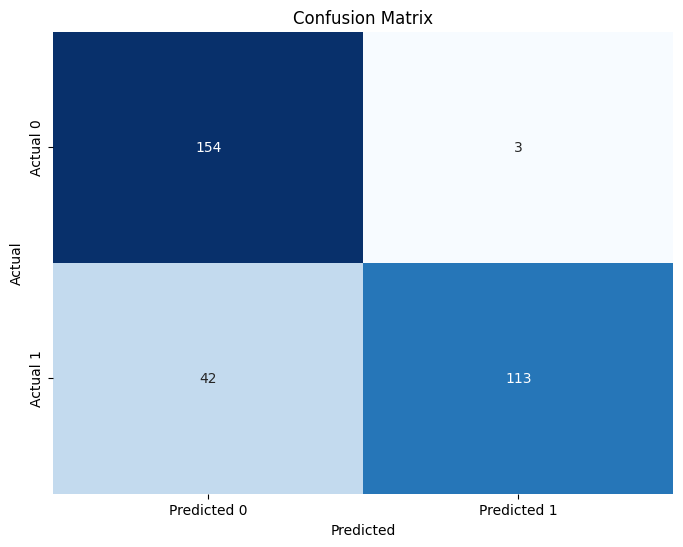

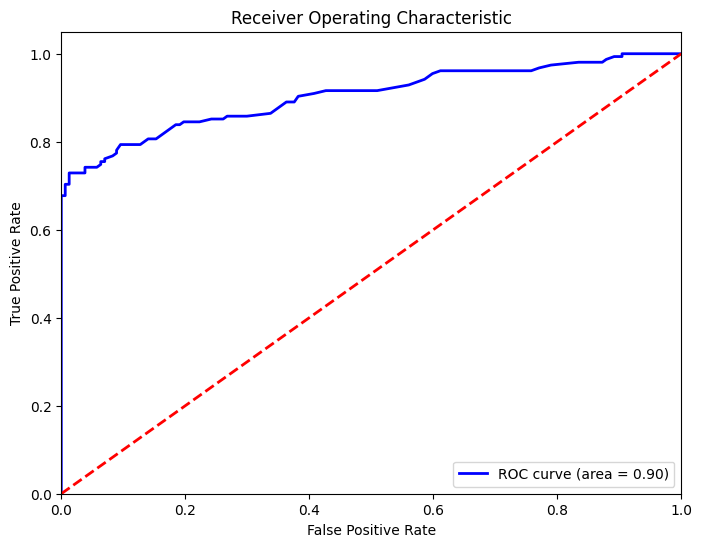

<ipython-input-163-7fab56afacdd>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')


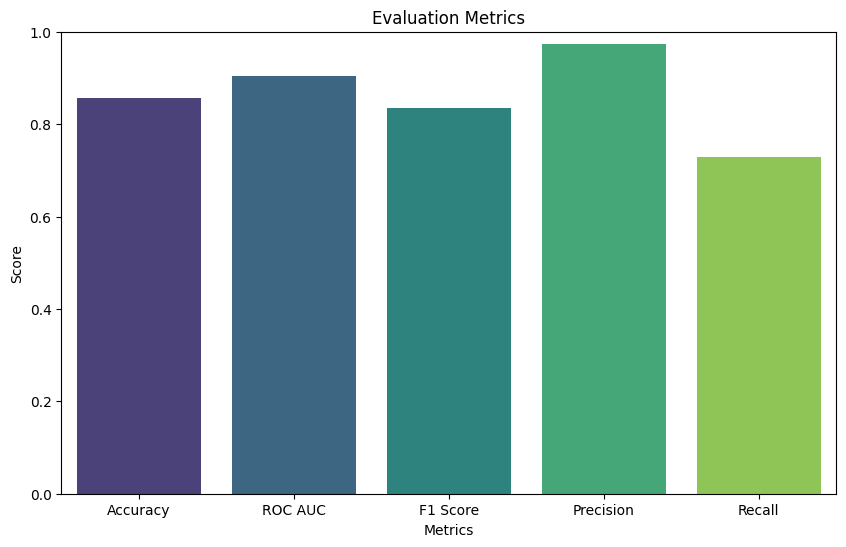

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Plotting the Confusion Matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# Function to plot ROC Curve
def plot_roc_curve(y_test, y_scores):
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# Function to plot bar charts for evaluation metrics
def plot_metrics(metrics):
    metrics_names = list(metrics.keys())
    metrics_values = list(metrics.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')
    plt.title('Evaluation Metrics')
    plt.ylabel('Score')
    plt.xlabel('Metrics')
    plt.ylim(0, 1)
    plt.show()

# Predict probabilities for ROC curve
y_scores = best_model.predict_proba(X_test)[:, 1]

# Call the plotting functions
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

plot_roc_curve(y_test, y_scores)

# Evaluation metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_scores),
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
}

plot_metrics(metrics)
